<a href="https://colab.research.google.com/github/Filbra/Colab_Earth_Engine/blob/main/Geepy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Python script code was developed by dr. F. Brandolini and G. Domingo-Ribas to accompany the paper: *Brandolini F., Domingo-Ribas G., Zerboni A. & Turner S. "A Google Earth Engine-enabled Python approach for the identification of anthropogenic palaeo-landscape features"*, Open Research Europe 2021, 1:22 (https://doi.org/10.12688/openreseurope.13135.1)

In [1]:
## Mounting your Google Drive in the runtime's virtual machine (Avoid this passage if you run the code in a local Jupyter Notebook session)

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
## Install Python Modules (Avoid this passage if you run the code in a local Jupyter Notebook session)

#! pip install geemap
#! pip install rasterio
#! pip install rioxarray

In [2]:
## Import Python Modules

import ee
import geemap
import os
import ipyleaflet

In [3]:
## Open a folium map object with 'geemap'

Map = geemap.Map()

Set your Area Of Interest (AOI) / Region Of Interest (ROI)
It could be done in two ways: 1) via Esri Shapefile (stored in your Drive), 2) creating a geometry object with coordinates. Here we present an example of method 2 with the coordinates of the Bronze Age Village "*Fabbrica dei Soci*" (see below).

In [5]:
## Method 1) to use a Esri Shapefile, set the shpfile path!
 
  ## aoi_shp = '/content/drive/My Drive/My Folder/My File.shp'
 
  ## Create your own AOI and ROI from Esri Shapefile!
 
  ## AOI = geemap.shp_to_ee(aoi_shp)
  ## ROI = AOI.geometry()

## Method 2) same ROI created setting a GEE geometry (this method do not require to upload any file in Drive!)

## TEST CASE AREA: Po Plain (Italy). The location of each archaeological site are indicated in the "ROIs.txt" file.

## Es.Bronze Age Village "Fabbrica dei Soci"

ROI = ee.Geometry.Polygon(
[[[11.349139311473449,45.09478572698541],
[11.348401747306402, 45.076797294992204],
[11.323013026554289, 45.077316817088835],
[11.323742634456798,45.095305573211924]]], 'EPSG:4326', False)


**Multi - temporal approach, Spectral indices & Spectral decomposition analysis** (*F. Brandolini*, filippo.brandolini@newcastle.ac.uk)

In [6]:
## This is the cloud masking function provided by GEE but adapted for use in Python.

def maskS2clouds(image):
  qa = image.select('QA60')
  cloudBitMask = 1 << 10
  cirrusBitMask = 1 << 11
  
  mask = qa.bitwiseAnd(cloudBitMask).eq(0).And(qa.bitwiseAnd(cirrusBitMask).eq(0))
  
  return image.updateMask(mask).divide(10000).select("B.*").copyProperties(image,["system:time_start"])

In [7]:
## Importing Copernicus Sentinel 2 data

## --> !!! The choice of the timespan depends on the environmental characteristics of the ROI !!! <--
## --> !!! The period chosen in this test area may not return valuable results in other zones / environments !!! <--
## --> !!! Adapt this part of the code to your needs !!! <--

In [8]:
## TEST CASE AREA: Po Plain (Italy)

## Filtering the autum/winter + winter/spring S2 collection and calculate the mean values

## February/April

Feb_Apr = (ee.ImageCollection('COPERNICUS/S2')
          .filterBounds(ROI)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .select(['B2','B3','B4','B8','B11','B12','QA60'])
          .filter(ee.Filter.dayOfYear(30,120)))
      
## October/December

Oct_Dec = (ee.ImageCollection('COPERNICUS/S2')
          .filterBounds(ROI)
          .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
          .select(['B2','B3','B4','B8','B11','B12','QA60'])
          .filter(ee.Filter.dayOfYear(270,360)))

## Merge

Merge = Feb_Apr.merge(Oct_Dec)
 
S2_coll = (Merge.map(maskS2clouds))

In [9]:
## Reducing the images collection in a single 6-bands image

S2_6bands = (S2_coll.select(['B2','B3','B4','B8','B11','B12']).mean().clip(ROI))

In [10]:
## RGB composite

## bands 4–3–2 (Red/Green/Blue), visualisation parameters:

RGB_vis = {
    'bands': ['B4', 'B3', 'B2'],
    'min': [0.0895036, 0.102564, 0.126852],
    'max': [0.121575, 0.123428, 0.143167],
  }

##  bands 12-8-4 (SWIR/NIR/Red), visualisation parameters:

SwirNirRed_vis = {
    'bands': ['B12', 'B8', 'B4'],
    'min': [0.0865478, 0.109573, 0.0872504],
    'max': [0.145608, 0.246046, 0.1266],
  }

In [11]:
## Bare Soil Index (BSI), formula: ((Red+SWIR) - (NIR+Blue)) / ((Red+SWIR) + (NIR+Blue))
## BSI (Sentinel 2) = (B11 + B4) – (B8 + B2) / (B11 + B4) + (B8 + B2)

BSI = S2_6bands.expression('((swir + red) - (nir + blue)) / ((swir + red) + (nir + blue))' ,{
    'nir':S2_6bands.select('B8'),
    'swir':S2_6bands.select('B12'),
    'red':S2_6bands.select('B4'),
    'blue':S2_6bands.select('B2'),
}).rename('BSI')

## BSI visualisation parameters:

BSI_vis = {
    'min': -0.2938584, 
    'max': -0.037054, 
    'palette': ['#d53e4f','#f46d43','#fdae61','#fee08b','#ffffbf','#e6f598','#abdda4','#66c2a5','#3288bd']} #Spectral


In [12]:
## Hue, Saturation and Value (HSV)
## Convert the RGB bands to the HSV color space.

HSV = (S2_coll.select(['B2','B3','B4']).mean().clip(ROI)).rgbToHsv()
HSV_vis = {'bands': ['hue', 'saturation', 'value'],
    'min': [0.00443054, 0.137734, 0.125822], 
    'max': [0.993581, 0.310943, 0.147081]
}


In [13]:
## Tassellation Cap Transformation (6 Bands)

## TCT components were computed using both the six bands described in the formulas 

## Create an Array of Tasseled Cap coefficients.
## • TCT-band 1 (brightness, measure of soil)
## • TCT-band 2 (greenness, measure of vegetation)
## • TCT-band 3 (wetness, interrelationship of soil and canopy moisture)

coefficients_6 = ee.Array([
  [0.3510, 0.3813, 0.3437, 0.7196, 0.2396, 0.1949], #TCTb
  [-0.3599, -0.3533, -0.4734, 0.6633, - 0.0087, -0.2856], #TCTg
  [0.2578, 0.2305, 0.0883, 0.1071, -0.7611, -0.5308], #TCTw
]);

## Make an Array Image, with a 1-D Array per pixel.
arrayImage1D = S2_6bands.toArray();

## Make an Array Image with a 2-D Array per pixel, 6x1.
arrayImage2D = arrayImage1D.toArray(1);

## Do a matrix multiplication: 6x6 times 6x1.
TCT = (ee.Image(coefficients_6)
          .matrixMultiply(arrayImage2D)
          .arrayProject([0])
          .arrayFlatten([['TCTb', 'TCTg', 'TCTw']]))

## Display the first three bands of the result and the input imagery.

TCT_vis = {
    'bands': ['TCTb', 'TCTg', 'TCTw'],
    'min': [0.255928, -0.0965299, -0.126619], 
    'max': [0.356473, -0.0218605, -0.0655193]
}

In [14]:
# PCA Principal Component Analysis

scale = 10
bandNames = S2_6bands.bandNames()

meanDict = S2_6bands.reduceRegion(**{
    'reducer': ee.Reducer.mean(),
    'geometry': ROI,
    'scale': scale,
    'maxPixels': 1e9
    })

means = ee.Image.constant(meanDict.values(bandNames))
centered = S2_6bands.subtract(means)

def getNewBandNames(prefix):
  seq = ee.List.sequence(1, bandNames.length())

  def func_zwm(b):
    return ee.String(prefix).cat(ee.Number(b).int().format())
  
  return seq.map(func_zwm)

def getPrincipalComponents(centered, scale, geometry):

## Collapse the bands of the image into a 1D array per pixel.
  arrays = centered.toArray()

##Compute the covariance of the bands within the region.
  covar = arrays.reduceRegion(**{
      'reducer': ee.Reducer.centeredCovariance(),
      'geometry': ROI,
      'scale': scale,
      'maxPixels': 1e9
      })
  
##Get the 'array' covariance result and cast to an array.
##This represents the band-to-band covariance within the region.

  covarArray = ee.Array(covar.get('array'))

## Perform an eigen analysis and slice apart the values and vectors.

  eigens = covarArray.eigen()

## This is a P-length vector of Eigenvalues.

  eigenValues = eigens.slice(1, 0, 1)

## This is a PxP matrix with eigenvectors in rows.

  eigenVectors = eigens.slice(1, 1)

## Convert the array image to 2D arrays for matrix computations.

  arrayImage = arrays.toArray(1)

## Left multiply the image array by the matrix of eigenvectors.

  principalComponents = ee.Image(eigenVectors).matrixMultiply(arrayImage)

## Turn the square roots of the Eigenvalues into a P-band image.

  sdImage = ee.Image(eigenValues.sqrt()) \
  .arrayProject([0]).arrayFlatten([getNewBandNames('sd')])

## Turn the PCs into a P-band image, normalized by SD.
  return principalComponents \
  .arrayProject([0]) \
  .arrayFlatten([getNewBandNames('pc')]) \
  .divide(sdImage)

# Get the PCs at the specified scale and in the specified region
PCA = getPrincipalComponents(centered, scale, ROI)

# Vis Parameters PCA

PCA_vis = {
    'bands': ['pc1', 'pc2', 'pc3'],
    'min': [-2.02982, -1.50828, -1.16942], 
    'max': [1.63844, 2.30986, 1.32921]
}

In [15]:
#Add Layers
Map.add_basemap(basemap='SATELLITE')
Map.addLayer(S2_6bands, RGB_vis, "RGB", True)
Map.addLayer(S2_6bands, SwirNirRed_vis, "FSWIR", True)
Map.addLayer(BSI, BSI_vis, "BSI", True)
Map.addLayer(HSV, HSV_vis, "HSV")
Map.addLayer(TCT, TCT_vis, "TCT", True)
Map.addLayer(PCA, PCA_vis, "PCA", True)

In [34]:
# Set map center
Map.center_object(S2_6bands, zoom = 16) 

In [33]:
Map.add_layer_control()
Map

The Inspector / Plot Geemap tool is only available running the code with Jupyter Notebook in a local session. This tool allows the user to assess the spectral signature of buried features in each outputs' band. Interactive plotting is for the *ipyleaflet* plotting backend only, but Google Colab does not support it yet. [More info here](https://geemap.org/faq/#why-does-geemap-use-two-plotting-backends-folium-and-ipyleaflet).

UPDATE 03/09/2021: Google Colab finally supports custom widgets (e.g., *ipyleaflet*): https://github.com/googlecolab/colabtools/issues/498#issuecomment-910755873 
The Inspector Tool should be availabe in Colab soon!

In [18]:
#Set Coordinates Reference Systems (CRS), For example: Italy --> 'EPSG:32632';  WGS 84 --> 'EPSG:4326'.

pjcrs = 'EPSG:32632'

In [19]:
## Generate image download URL. If your ara running the code in Colab, the outputs are saved automatically in the sample_data folder in your Drive

geemap.ee_export_image(ee_object= S2_6bands, filename='RGB.tif',scale=10,crs= pjcrs,region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= S2_6bands, filename='FSWIR.tif',scale=10,crs= pjcrs,region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= BSI, filename='BSI.tif',scale=10,crs= pjcrs,region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= HSV, filename='HSV.tif',scale=10,crs= pjcrs,region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= TCT, filename='TCT.tif',scale=10,crs= pjcrs,region= ROI, file_per_band= False)
geemap.ee_export_image(ee_object= PCA, filename='PCA.tif',scale=10,crs= pjcrs,region= ROI, file_per_band= False)

Generating URL ...
Please wait ...
Data downloaded to /content/RGB.tif
Generating URL ...
Please wait ...
Data downloaded to /content/FSWIR.tif
Generating URL ...
Please wait ...
Data downloaded to /content/BSI.tif
Generating URL ...
Please wait ...
Data downloaded to /content/HSV.tif
Generating URL ...
Please wait ...
Data downloaded to /content/TCT.tif
Generating URL ...
Please wait ...
Data downloaded to /content/PCA.tif


If you run the code in a Colab cloud session, the outputs are saved automatically in the */content/sample_data* folder in your Drive. In a local session the outputs will be saved in the same directory where your saved the *.ipynb* file.

**Outputs' bands plotting** (*G. Domingo-Ribas*, G.Domingo-Ribas2@newcastle.ac.uk )

In [20]:
## Import Python Modules

import matplotlib
import rasterio
import numpy as np
import os
%matplotlib inline
from rasterio.plot import show
from rasterio.plot import show_hist
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import matplotlib.font_manager as fm
from osgeo import gdal
import os
import rioxarray as rxr
%matplotlib inline

## Import files (if you are running the code in Jupyter Notebook on a local machine, please update this part with the corresponding path of each output in your directory)

rgbR = rasterio.open("/content/RGB.tif")
fswirR = rasterio.open("/content/FSWIR.tif")
bsiR = rasterio.open("/content/BSI.tif")
hsvR = rasterio.open("/content/HSV.tif")
tctR = rasterio.open("/content/TCT.tif")
pcaR = rasterio.open("/content/PCA.tif")

In [21]:
rgbBandNames = S2_6bands.bandNames()
print(rgbBandNames.getInfo())

['B2', 'B3', 'B4', 'B8', 'B11', 'B12']


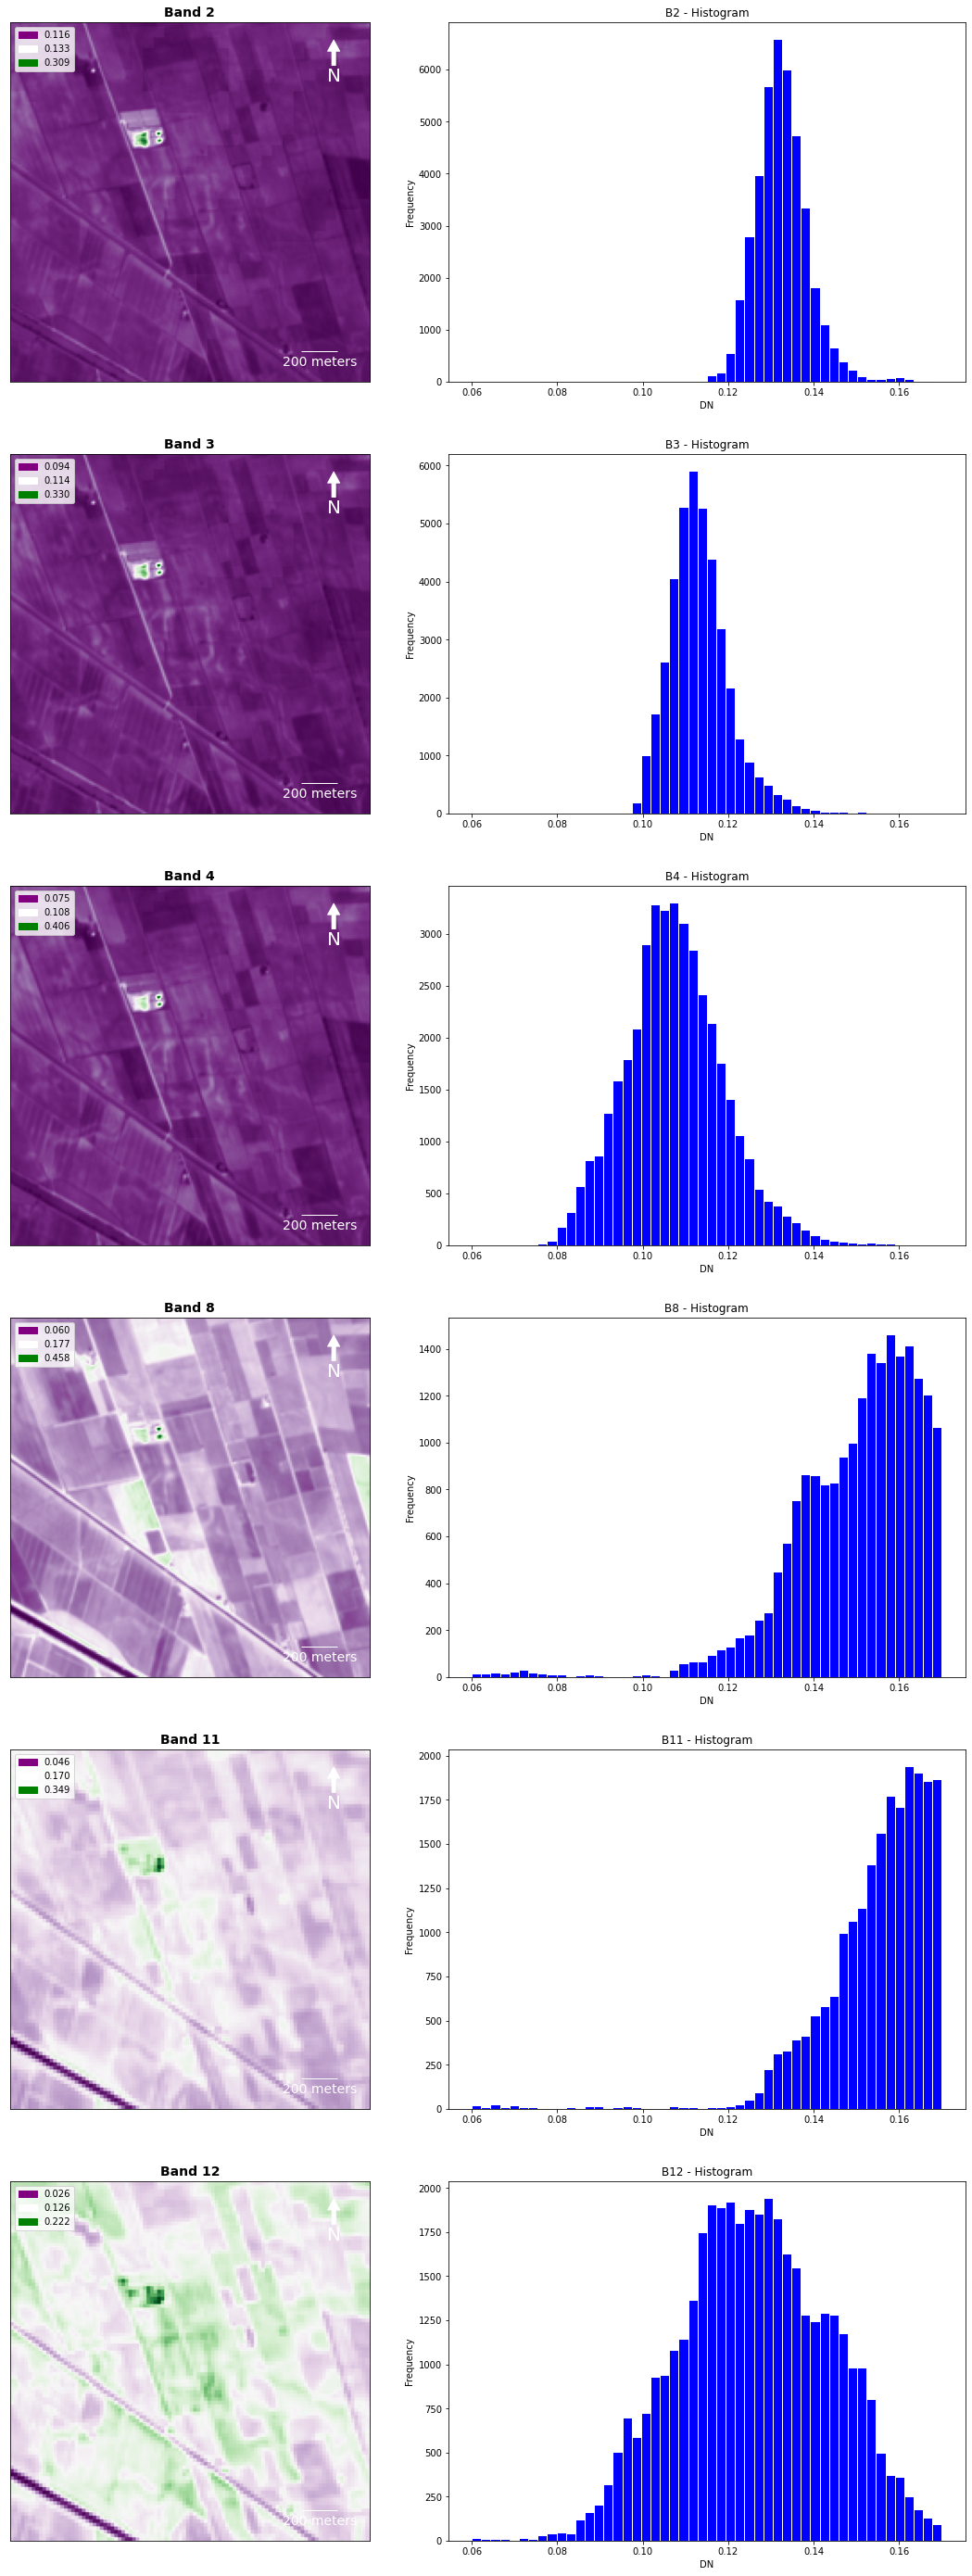

In [22]:
# Plot Bands 2, 3, 4, 8, 11, 12 and histograms
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(ncols=2, nrows=6, figsize=(20, 50))

"""
PLOT ALL BANDS
"""
show((rgbR, 1), ax=ax1, label=None, cmap = 'PRGn')
show((rgbR, 2), ax=ax3, label=None, cmap = 'PRGn')
show((rgbR, 3), ax=ax5, label=None, cmap = 'PRGn')
show((rgbR, 4), ax=ax7, label=None, cmap = 'PRGn')
show((rgbR, 5), ax=ax9, label=None, cmap = 'PRGn')
show((rgbR, 6), ax=ax11, label=None, cmap = 'PRGn')

# Adjust the space between plots
#plt.subplots_adjust(wspace=0, hspace=0)

# Add a scalebar
fontprops = fm.FontProperties(size=14, family='sans')
bar1 = AnchoredSizeBar(ax1.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar2 = AnchoredSizeBar(ax3.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar3 = AnchoredSizeBar(ax5.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar4 = AnchoredSizeBar(ax7.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar5 = AnchoredSizeBar(ax9.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar6 = AnchoredSizeBar(ax11.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
ax1.add_artist(bar1)
ax3.add_artist(bar2)
ax5.add_artist(bar3)
ax7.add_artist(bar4)
ax9.add_artist(bar5)
ax11.add_artist(bar6)

# Add north arrow
x, y, arrow_length = 0.9, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax1.transAxes)
ax3.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax3.transAxes)
ax5.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax5.transAxes)
ax7.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax7.transAxes)
ax9.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax9.transAxes)
ax11.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax11.transAxes)

# Hide y axis
ax1.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)
ax9.get_yaxis().set_visible(False)
ax11.get_yaxis().set_visible(False)

# Hide x axis
ax1.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)
ax7.get_xaxis().set_visible(False)
ax9.get_xaxis().set_visible(False)
ax11.get_xaxis().set_visible(False)

# If you show the axis, rotate the coordinates of the x axis
# ax1.tick_params('x', labelrotation=45)
# ax2.tick_params('x', labelrotation=45)
# ax3.tick_params('x', labelrotation=45)

# Add titles
ax1.set_title("Band 2", fontsize=14, fontweight='bold')
ax3.set_title("Band 3", fontsize=14, fontweight='bold')
ax5.set_title("Band 4", fontsize=14, fontweight='bold')
ax7.set_title("Band 8", fontsize=14, fontweight='bold')
ax9.set_title("Band 11", fontsize=14, fontweight='bold')
ax11.set_title("Band 12", fontsize=14, fontweight='bold')

# Calculate Statistics of each band: 0-Minimum / 1-Maximum / 2-Mean / 3-StDev
src_ds = gdal.Open("/content/RGB.tif")

stats_1 = src_ds.GetRasterBand(1).GetStatistics(False, True)
stats_2 = src_ds.GetRasterBand(2).GetStatistics(False, True)
stats_3 = src_ds.GetRasterBand(3).GetStatistics(False, True)
stats_4 = src_ds.GetRasterBand(4).GetStatistics(False, True)
stats_5 = src_ds.GetRasterBand(5).GetStatistics(False, True)
stats_6 = src_ds.GetRasterBand(6).GetStatistics(False, True)

# Add a legend
legend_labels_ax1 = {"purple": "%.3f" % stats_1[0], "white": "%.3f" % stats_1[2], "green": "%.3f" % stats_1[1]}
legend_labels_ax3 = {"purple": "%.3f" % stats_2[0], "white": "%.3f" % stats_2[2], "green": "%.3f" % stats_2[1]}
legend_labels_ax5 = {"purple": "%.3f" % stats_3[0], "white": "%.3f" % stats_3[2], "green": "%.3f" % stats_3[1]}
legend_labels_ax7 = {"purple": "%.3f" % stats_4[0], "white": "%.3f" % stats_4[2], "green": "%.3f" % stats_4[1]}
legend_labels_ax9 = {"purple": "%.3f" % stats_5[0], "white": "%.3f" % stats_5[2], "green": "%.3f" % stats_5[1]}
legend_labels_ax11 = {"purple": "%.3f" % stats_6[0], "white": "%.3f" % stats_6[2], "green": "%.3f" % stats_6[1]}


patches_ax1 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax1.items()]
patches_ax3 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax3.items()]
patches_ax5 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax5.items()]
patches_ax7 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax7.items()]
patches_ax9 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax9.items()]
patches_ax11 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax11.items()]

ax1.legend(handles=patches_ax1,
          loc='upper left',
          facecolor="white")
ax3.legend(handles=patches_ax3,
          loc='upper left',
          facecolor="white")
ax5.legend(handles=patches_ax5,
          loc='upper left',
          facecolor="white")
ax7.legend(handles=patches_ax7,
          loc='upper left',
          facecolor="white")
ax9.legend(handles=patches_ax9,
          loc='upper left',
          facecolor="white")
ax11.legend(handles=patches_ax11,
          loc='upper left',
          facecolor="white")

"""
PLOT BAND HISTOGRAMS
"""

rgbR_path = ("/content/RGB.tif")

rgb_im = rxr.open_rasterio(rgbR_path, masked=True)

# Access each band
rgb_b1 = rgb_im.sel(band=1)
rgb_b2 = rgb_im.sel(band=2)
rgb_b3 = rgb_im.sel(band=3)
rgb_b4 = rgb_im.sel(band=4)
rgb_b5 = rgb_im.sel(band=5)
rgb_b6 = rgb_im.sel(band=6)

# Create the histograms
rgb_b1.plot.hist(ax=ax2,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.06, 0.17)) # The range (min, max) values have been added manually for creating more meaningful histograms
ax2.set(title="B2 - Histogram",
       xlabel='DN',
       ylabel='Frequency')


rgb_b2.plot.hist(ax=ax4,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.06, 0.17))
ax4.set(title="B3 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

rgb_b3.plot.hist(ax=ax6,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.06, 0.17))
ax6.set(title="B4 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

rgb_b4.plot.hist(ax=ax8,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.06, 0.17))
ax8.set(title="B8 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

rgb_b5.plot.hist(ax=ax10,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.06, 0.17))
ax10.set(title="B11 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

rgb_b6.plot.hist(ax=ax12,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.06, 0.17))
ax12.set(title="B12 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

# Adjust the plots
plt.subplots_adjust(wspace=0, hspace=0.2)


# Save jpeg image
plt.savefig("rgbFswirBands_plot.tif", dpi = 300)

In [23]:
bsiBandNames = BSI.bandNames()
print(bsiBandNames.getInfo())

['BSI']


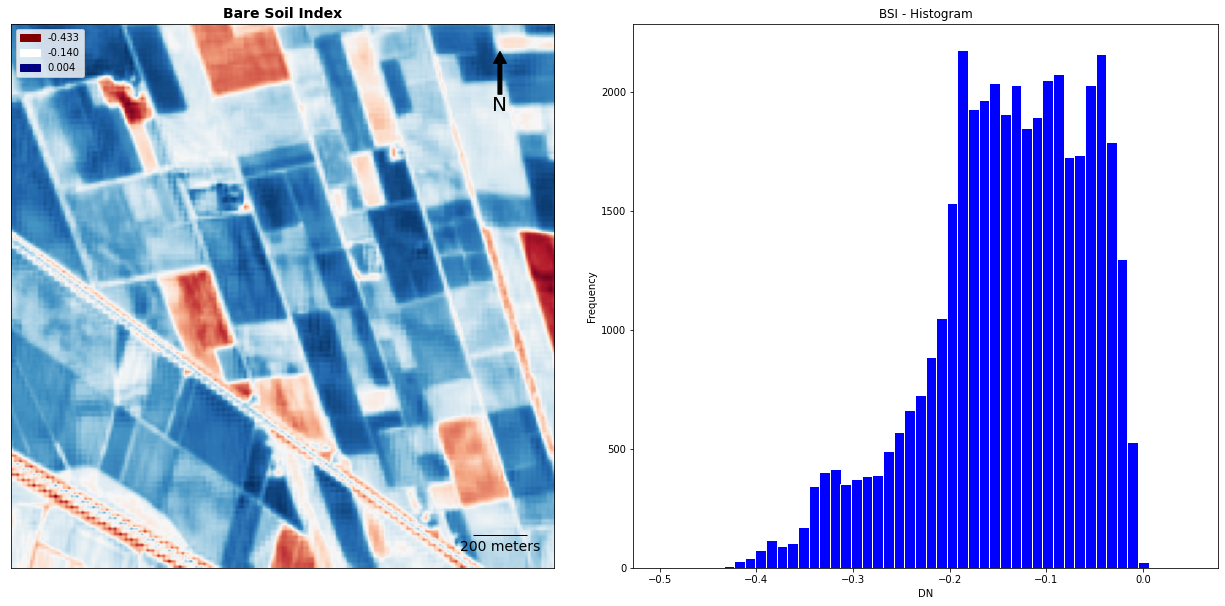

In [24]:
# Plot Bare Soil Index (BSI) Band and histogram
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(22, 10))

"""
PLOT BSI
"""

show((bsiR), ax=ax1, label=None, cmap = 'RdBu')

# Add a scalebar
fontprops = fm.FontProperties(size=14, family='sans')
bar1 = AnchoredSizeBar(ax1.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
ax1.add_artist(bar1)

# Add north arrow
x, y, arrow_length = 0.9, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax1.transAxes)

# Hide y axis
ax1.get_yaxis().set_visible(False)

# Hide x axis
ax1.get_xaxis().set_visible(False)

# If you show the axis, rotate the coordinates of the x axis
# ax.tick_params('x', labelrotation=45)

# Add title
ax1.set_title("Bare Soil Index", fontsize=14, fontweight='bold')

# Calculate Statistics of the band: 0-Minimum / 1-Maximum / 2-Mean / 3-StDev
src_ds = gdal.Open("/content/BSI.tif")

stats_1 = src_ds.GetRasterBand(1).GetStatistics(False, True)

# Add a legend
legend_labels_ax = {"maroon": "%.3f" % stats_1[0], "white": "%.3f" % stats_1[2], "navy": "%.3f" % stats_1[1]}

patches_ax = [Patch(color=color, label=label)
           for color, label in legend_labels_ax.items()]

ax1.legend(handles=patches_ax,
          loc='upper left',
          facecolor="white")


"""
PLOT HISTOGRAM
"""
bsiR_path = ("/content/BSI.tif")

bsi_im = rxr.open_rasterio(bsiR_path, masked=True)

# Access the band
bsi_b1 = bsi_im.sel(band=1)

# Create the histogram
bsi_b1.plot.hist(ax=ax2,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-0.5, 0.05)) # The range (min, max) values have been added manually for creating more meaningful histograms
ax2.set(title="BSI - Histogram",
       xlabel='DN',
       ylabel='Frequency')

# Adjust the plots
plt.subplots_adjust(wspace=0.1, hspace=0.2)

# Save jpeg image
plt.savefig("bsiBands_plot.jpeg", quality = 99)

In [25]:
hsvBandNames = HSV.bandNames()
print(hsvBandNames.getInfo())

['hue', 'saturation', 'value']


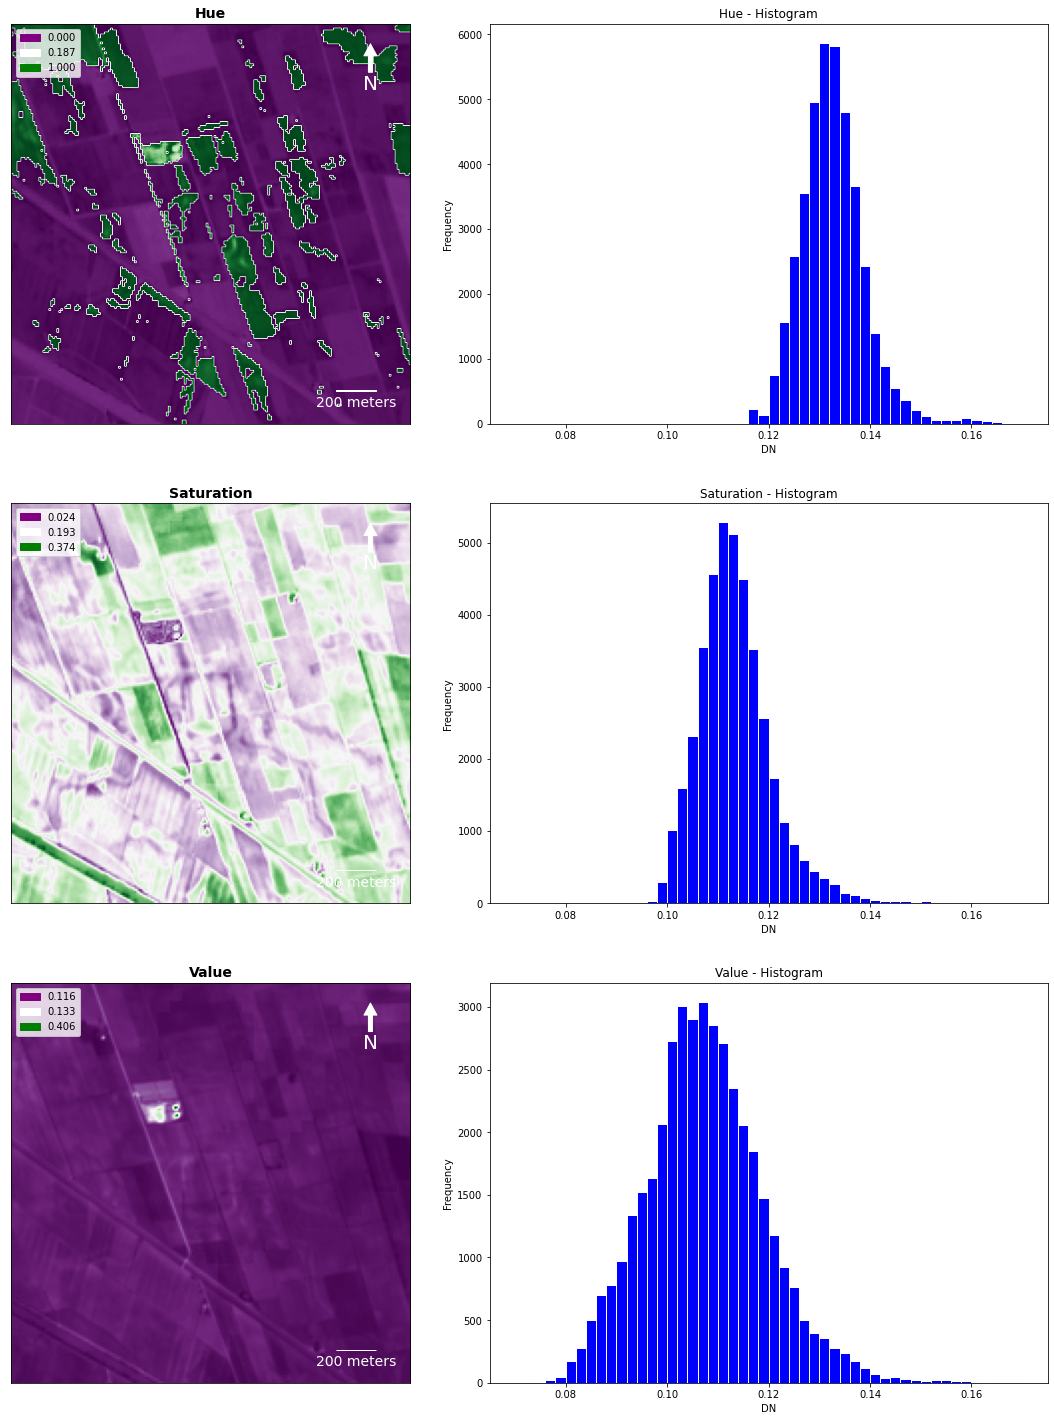

In [26]:
# Plot all Hue, Saturation and Value (HSV) Bands and histograms
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(20, 25))

"""
PLOT ALL RGB BANDS
"""
show((hsvR, 1), ax=ax1, label=None, cmap = 'PRGn')
show((hsvR, 2), ax=ax3, label=None, cmap = 'PRGn')
show((hsvR, 3), ax=ax5, label=None, cmap = 'PRGn')

# Add a scalebar
fontprops = fm.FontProperties(size=14, family='sans')
bar1 = AnchoredSizeBar(ax1.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar2 = AnchoredSizeBar(ax3.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar3 = AnchoredSizeBar(ax5.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
ax1.add_artist(bar1)
ax3.add_artist(bar2)
ax5.add_artist(bar3)

# Add north arrow
x, y, arrow_length = 0.9, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax1.transAxes)
ax3.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax3.transAxes)
ax5.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax5.transAxes)

# Hide y axis
ax1.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)

# Hide x axis
ax1.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)

# If you show the axis, rotate the coordinates of the x axis
# ax1.tick_params('x', labelrotation=45)
# ax2.tick_params('x', labelrotation=45)
# ax3.tick_params('x', labelrotation=45)

# Add titles
ax1.set_title("Hue", fontsize=14, fontweight='bold')
ax3.set_title("Saturation", fontsize=14, fontweight='bold')
ax5.set_title("Value", fontsize=14, fontweight='bold')

# Calculate Statistics of each band: 0-Minimum / 1-Maximum / 2-Mean / 3-StDev
src_ds = gdal.Open("/content/HSV.tif")

stats_1 = src_ds.GetRasterBand(1).GetStatistics(False, True)
stats_2 = src_ds.GetRasterBand(2).GetStatistics(False, True)
stats_3 = src_ds.GetRasterBand(3).GetStatistics(False, True)

# Add a legend
legend_labels_ax1 = {"purple": "%.3f" % stats_1[0], "white": "%.3f" % stats_1[2], "green": "%.3f" % stats_1[1]}
legend_labels_ax3 = {"purple": "%.3f" % stats_2[0], "white": "%.3f" % stats_2[2], "green": "%.3f" % stats_2[1]}
legend_labels_ax5 = {"purple": "%.3f" % stats_3[0], "white": "%.3f" % stats_3[2], "green": "%.3f" % stats_3[1]}


patches_ax1 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax1.items()]
patches_ax3 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax3.items()]
patches_ax5 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax5.items()]

ax1.legend(handles=patches_ax1,
          loc='upper left',
          facecolor="white")
ax3.legend(handles=patches_ax3,
          loc='upper left',
          facecolor="white")
ax5.legend(handles=patches_ax5,
          loc='upper left',
          facecolor="white")

"""
PLOT BAND HISTOGRAMS
"""

hsvR_path = ("/content/HSV.tif")

hsv_im = rxr.open_rasterio(hsvR_path, masked=True)

# Access each band
hsv_b1 = rgb_im.sel(band=1)
hsv_b2 = rgb_im.sel(band=2)
hsv_b3 = rgb_im.sel(band=3)

# Create the histograms
hsv_b1.plot.hist(ax=ax2,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.07, 0.17)) # The range (min, max) values have been added manually for creating more meaningful histograms
ax2.set(title="Hue - Histogram",
       xlabel='DN',
       ylabel='Frequency')


hsv_b2.plot.hist(ax=ax4,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.07, 0.17))
ax4.set(title="Saturation - Histogram",
       xlabel='DN',
       ylabel='Frequency')

hsv_b3.plot.hist(ax=ax6,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(0.07, 0.17))
ax6.set(title="Value - Histogram",
       xlabel='DN',
       ylabel='Frequency')


# Adjust the plots
plt.subplots_adjust(wspace=0, hspace=0.2)


# Save jpeg image
plt.savefig("hsvBands_plot.tif", dpi = 300)

In [27]:
tctBandNames = TCT.bandNames()
print(tctBandNames.getInfo())

['TCTb', 'TCTg', 'TCTw']


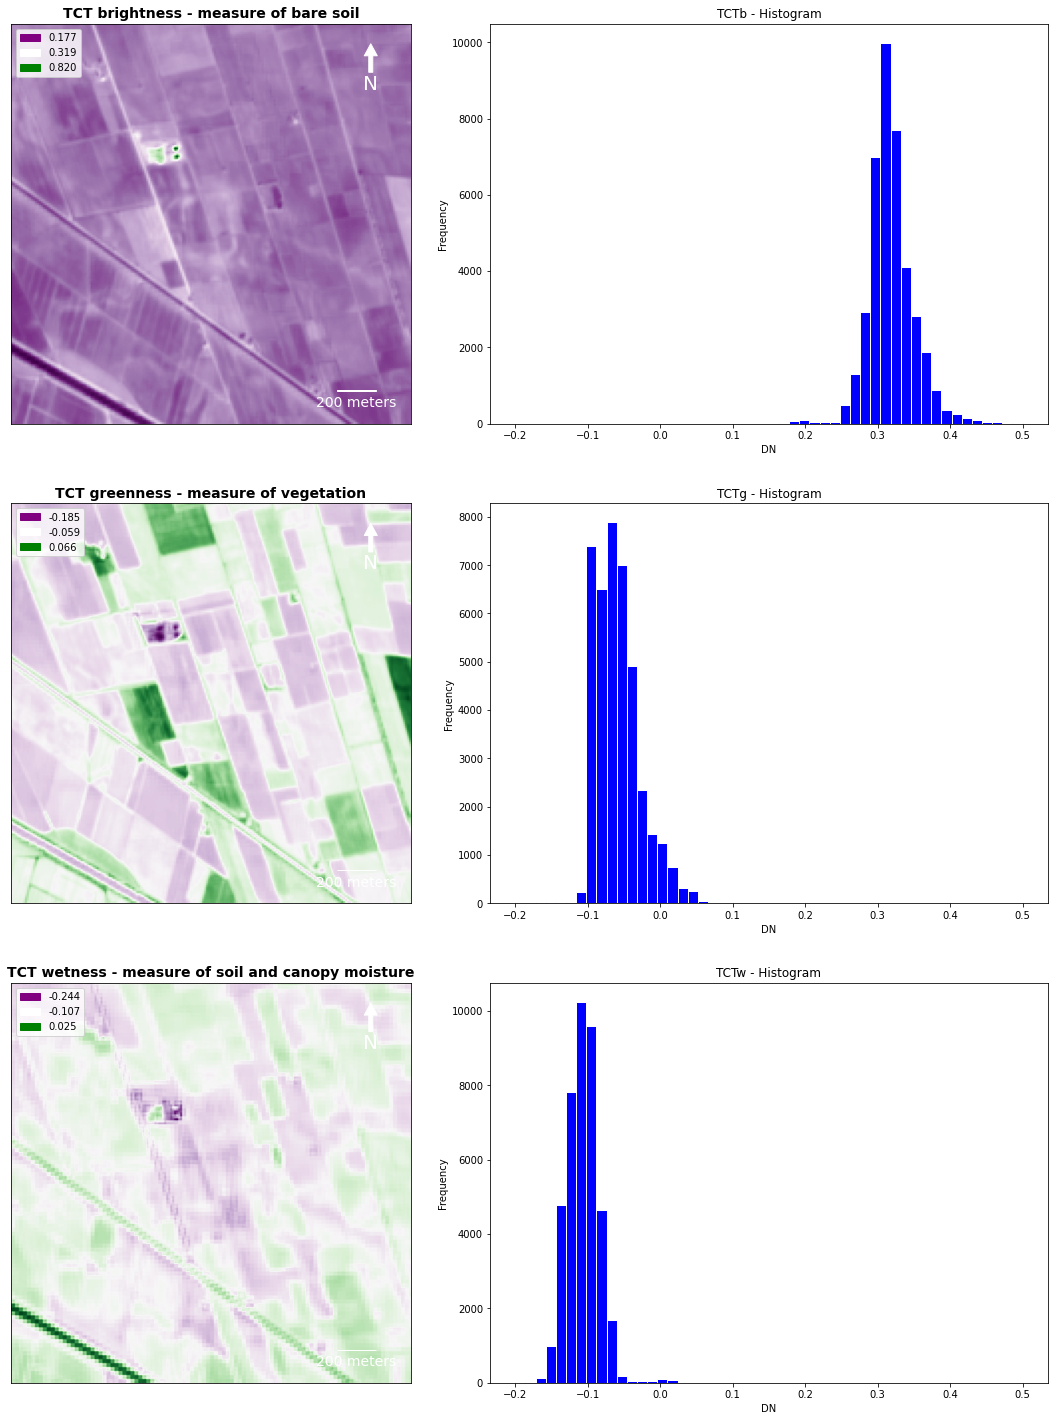

In [28]:
# Plot all Tasselled cap transformation (TCT) bands
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(ncols=2, nrows=3, figsize=(20, 25))

"""
PLOT ALL TCT BANDS
"""
show((tctR, 1), ax=ax1, label=None, cmap = 'PRGn')
show((tctR, 2), ax=ax3, label=None, cmap = 'PRGn')
show((tctR, 3), ax=ax5, label=None, cmap = 'PRGn')

# Adjust the space between plots
#plt.subplots_adjust(wspace=0, hspace=0)

# Add a scalebar
fontprops = fm.FontProperties(size=14, family='sans')
bar1 = AnchoredSizeBar(ax1.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar2 = AnchoredSizeBar(ax3.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
bar3 = AnchoredSizeBar(ax5.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='white', fontproperties=fontprops)
ax1.add_artist(bar1)
ax3.add_artist(bar2)
ax5.add_artist(bar3)

# Add north arrow
x, y, arrow_length = 0.9, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax1.transAxes)
ax3.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax3.transAxes)
ax5.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='white', edgecolor='white', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='white',
            xycoords=ax5.transAxes)

# Hide y axis
ax1.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)

# Hide x axis
ax1.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)

# If you show the axis, rotate the coordinates of the x axis
# ax1.tick_params('x', labelrotation=45)
# ax2.tick_params('x', labelrotation=45)
# ax3.tick_params('x', labelrotation=45)

# Add titles
ax1.set_title("TCT brightness - measure of bare soil", fontsize=14, fontweight='bold')
ax3.set_title("TCT greenness - measure of vegetation", fontsize=14, fontweight='bold')
ax5.set_title("TCT wetness - measure of soil and canopy moisture", fontsize=14, fontweight='bold')

# Calculate Statistics of each band: 0-Minimum / 1-Maximum / 2-Mean / 3-StDev
src_ds = gdal.Open("/content/TCT.tif")

stats_1 = src_ds.GetRasterBand(1).GetStatistics(False, True)
stats_2 = src_ds.GetRasterBand(2).GetStatistics(False, True)
stats_3 = src_ds.GetRasterBand(3).GetStatistics(False, True)

# Add a legend
legend_labels_ax1 = {"purple": "%.3f" % stats_1[0], "white": "%.3f" % stats_1[2], "green": "%.3f" % stats_1[1]}
legend_labels_ax3 = {"purple": "%.3f" % stats_2[0], "white": "%.3f" % stats_2[2], "green": "%.3f" % stats_2[1]}
legend_labels_ax5 = {"purple": "%.3f" % stats_3[0], "white": "%.3f" % stats_3[2], "green": "%.3f" % stats_3[1]}


patches_ax1 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax1.items()]
patches_ax3 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax3.items()]
patches_ax5 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax5.items()]

ax1.legend(handles=patches_ax1,
          loc='upper left',
          facecolor="white")
ax3.legend(handles=patches_ax3,
          loc='upper left',
          facecolor="white")
ax5.legend(handles=patches_ax5,
          loc='upper left',
          facecolor="white")

"""
PLOT BAND HISTOGRAMS
"""

tctR_path = ("/content/TCT.tif")

tct_im = rxr.open_rasterio(tctR_path, masked=True)

# Access each band
tct_b1 = tct_im.sel(band=1)
tct_b2 = tct_im.sel(band=2)
tct_b3 = tct_im.sel(band=3)

# Create the histograms
tct_b1.plot.hist(ax=ax2,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-0.2, 0.5)) # The range (min, max) values have been added manually for creating more meaningful histograms
ax2.set(title="TCTb - Histogram",
       xlabel='DN',
       ylabel='Frequency')


tct_b2.plot.hist(ax=ax4,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-0.2, 0.5))
ax4.set(title="TCTg - Histogram",
       xlabel='DN',
       ylabel='Frequency')

tct_b3.plot.hist(ax=ax6,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-0.2, 0.5))
ax6.set(title="TCTw - Histogram",
       xlabel='DN',
       ylabel='Frequency')


# Adjust the plots
plt.subplots_adjust(wspace=0, hspace=0.2)


# Save jpeg image
plt.savefig("tctBands_plot.tif", dpi = 300)

In [29]:
# PCA Band Names
pcaBandNames = PCA.bandNames()
print(pcaBandNames.getInfo())

['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6']


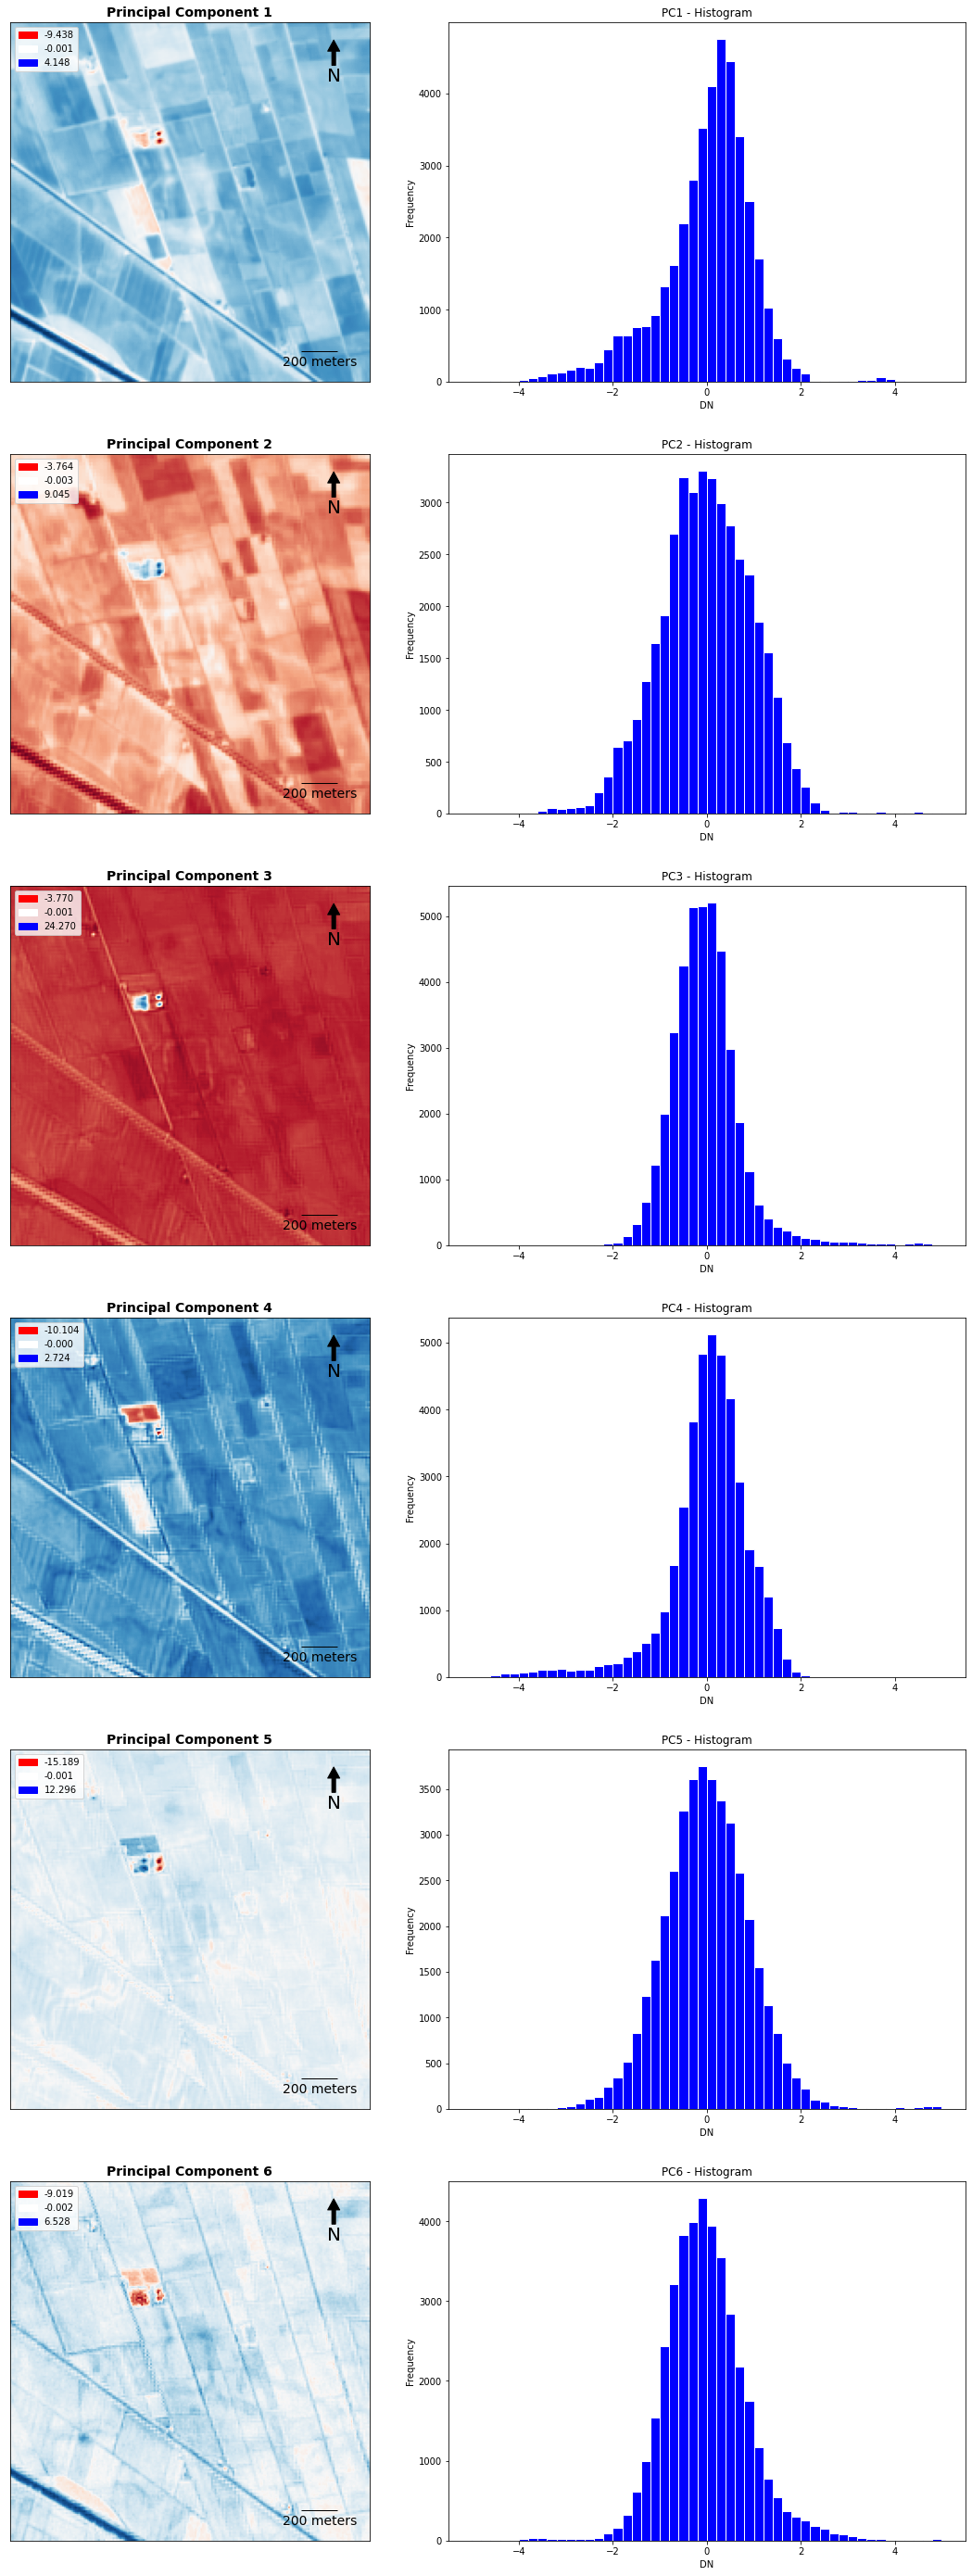

In [30]:
# Plot all Principal Components
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8), (ax9, ax10), (ax11, ax12)) = plt.subplots(ncols=2, nrows=6, figsize=(20, 50))

"""
PLOT EACH BAND
"""

show((pcaR, 1), ax=ax1, label=None, cmap = 'RdBu')
show((pcaR, 2), ax=ax3, label=None, cmap = 'RdBu')
show((pcaR, 3), ax=ax5, label=None, cmap = 'RdBu')
show((pcaR, 4), ax=ax7, label=None, cmap = 'RdBu')
show((pcaR, 5), ax=ax9, label=None, cmap = 'RdBu')
show((pcaR, 6), ax=ax11, label=None, cmap = 'RdBu')


# Add a scalebar
fontprops = fm.FontProperties(size=14, family='sans')
bar1 = AnchoredSizeBar(ax1.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar2 = AnchoredSizeBar(ax3.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar3 = AnchoredSizeBar(ax5.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar4 = AnchoredSizeBar(ax7.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar5 = AnchoredSizeBar(ax9.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
bar6 = AnchoredSizeBar(ax11.transData, 200, '200 meters', 4, pad=0.5, sep=5, borderpad=0.5, 
                      frameon=False, size_vertical=0.5, color='black', fontproperties=fontprops)
ax1.add_artist(bar1)
ax3.add_artist(bar2)
ax5.add_artist(bar3)
ax7.add_artist(bar4)
ax9.add_artist(bar5)
ax11.add_artist(bar6)

# Add north arrow
x, y, arrow_length = 0.9, 0.95, 0.1
ax1.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax1.transAxes)
ax3.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax3.transAxes)
ax5.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax5.transAxes)
ax7.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax7.transAxes)
ax9.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax9.transAxes)
ax11.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', edgecolor='black', width=4, headwidth=13),
            ha='center', va='center', fontsize=20, color='black',
            xycoords=ax11.transAxes)

# Hide y axis
ax1.get_yaxis().set_visible(False)
ax3.get_yaxis().set_visible(False)
ax5.get_yaxis().set_visible(False)
ax7.get_yaxis().set_visible(False)
ax9.get_yaxis().set_visible(False)
ax11.get_yaxis().set_visible(False)

# Hide x axis
ax1.get_xaxis().set_visible(False)
ax3.get_xaxis().set_visible(False)
ax5.get_xaxis().set_visible(False)
ax7.get_xaxis().set_visible(False)
ax9.get_xaxis().set_visible(False)
ax11.get_xaxis().set_visible(False)

# Add titles
ax1.set_title("Principal Component 1", fontsize=14, fontweight='bold')
ax3.set_title("Principal Component 2", fontsize=14, fontweight='bold')
ax5.set_title("Principal Component 3", fontsize=14, fontweight='bold')
ax7.set_title("Principal Component 4", fontsize=14, fontweight='bold')
ax9.set_title("Principal Component 5", fontsize=14, fontweight='bold')
ax11.set_title("Principal Component 6", fontsize=14, fontweight='bold')

# Calculate Statistics of each band: 0-Minimum / 1-Maximum / 2-Mean / 3-StDev
src_ds = gdal.Open("/content/PCA.tif")

stats_1 = src_ds.GetRasterBand(1).GetStatistics(False, True)
stats_2 = src_ds.GetRasterBand(2).GetStatistics(False, True)
stats_3 = src_ds.GetRasterBand(3).GetStatistics(False, True)
stats_4 = src_ds.GetRasterBand(4).GetStatistics(False, True)
stats_5 = src_ds.GetRasterBand(5).GetStatistics(False, True)
stats_6 = src_ds.GetRasterBand(6).GetStatistics(False, True)

# Add a legend
legend_labels_ax1 = {"Red": "%.3f" % stats_1[0], "white": "%.3f" % stats_1[2], "blue": "%.3f" % stats_1[1]}
legend_labels_ax3 = {"Red": "%.3f" % stats_2[0], "white": "%.3f" % stats_2[2], "blue": "%.3f" % stats_2[1]}
legend_labels_ax5 = {"Red": "%.3f" % stats_3[0], "white": "%.3f" % stats_3[2], "blue": "%.3f" % stats_3[1]}
legend_labels_ax7 = {"Red": "%.3f" % stats_4[0], "white": "%.3f" % stats_4[2], "blue": "%.3f" % stats_4[1]}
legend_labels_ax9 = {"Red": "%.3f" % stats_5[0], "white": "%.3f" % stats_5[2], "blue": "%.3f" % stats_5[1]}
legend_labels_ax11 = {"Red": "%.3f" % stats_6[0], "white": "%.3f" % stats_6[2], "blue": "%.3f" % stats_6[1]}

patches_ax1 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax1.items()]
patches_ax3 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax3.items()]
patches_ax5 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax5.items()]
patches_ax7 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax7.items()]
patches_ax9 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax9.items()]
patches_ax11 = [Patch(color=color, label=label)
           for color, label in legend_labels_ax11.items()] 

ax1.legend(handles=patches_ax1,
          loc='upper left',
          facecolor="white")
ax3.legend(handles=patches_ax3,
          loc='upper left',
          facecolor="white")
ax5.legend(handles=patches_ax5,
          loc='upper left',
          facecolor="white")
ax7.legend(handles=patches_ax7,
          loc='upper left',
          facecolor="white")
ax9.legend(handles=patches_ax9,
          loc='upper left',
          facecolor="white")
ax11.legend(handles=patches_ax11,
          loc='upper left',
          facecolor="white")


"""
PLOT BAND HISTOGRAMS
"""

pcaR_path = ("/content/PCA.tif")

pca_im = rxr.open_rasterio(pcaR_path, masked=True)

# Access each band
pca_b1 = pca_im.sel(band=1)
pca_b2 = pca_im.sel(band=2)
pca_b3 = pca_im.sel(band=3)
pca_b4 = pca_im.sel(band=4)
pca_b5 = pca_im.sel(band=5)
pca_b6 = pca_im.sel(band=6)

# Create the histograms
pca_b1.plot.hist(ax=ax2,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-5, 5)) # The range (min, max) values have been added manually for creating more meaningful histograms
ax2.set(title="PC1 - Histogram",
       xlabel='DN',
       ylabel='Frequency')


pca_b2.plot.hist(ax=ax4,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-5, 5))
ax4.set(title="PC2 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

pca_b3.plot.hist(ax=ax6,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-5, 5))
ax6.set(title="PC3 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

pca_b4.plot.hist(ax=ax8,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-5, 5))
ax8.set(title="PC4 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

pca_b5.plot.hist(ax=ax10,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-5, 5))
ax10.set(title="PC5 - Histogram",
       xlabel='DN',
       ylabel='Frequency')

pca_b6.plot.hist(ax=ax12,
                 color="blue",
                 edgecolor="white",
                 bins=50,
                 range=(-5, 5))
ax12.set(title="PC6 - Histogram",
       xlabel='DN',
       ylabel='Frequency')


# Adjust the plots
plt.subplots_adjust(wspace=0, hspace=0.2)


# Save jpeg image
plt.savefig("pcaBands_plot.tif", dpi = 300)